In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_ind


c:\Users\saumy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


      Subgroup                  Category      N        MAE         MSE  \
0     AgeGroup                       <30   5191   9.139723  152.234253   
1     AgeGroup                       50+   3902  10.604480  205.463165   
2     AgeGroup                     30-50   4070   9.686409  171.176697   
3          Sex                      Male  10024   9.865820  179.565338   
4          Sex                    Female   3676   9.867230  176.815216   
5   Employment                  Employed   7544   9.327497  155.433243   
6   Employment      Retired: Age-related   1277  12.171670  272.782166   
7   Employment                   Unknown   1676   9.270906  160.223145   
8   Employment       Unemployed: Looking    746  10.466045  205.213974   
9   Employment         Full-Time Student    690   9.131829  153.160614   
10  Employment         House/Family Care    242  10.068224  179.195862   
11  Employment       Retired: Disability    651  11.621301  241.138489   
12  Employment   Unemployed: Not Looki

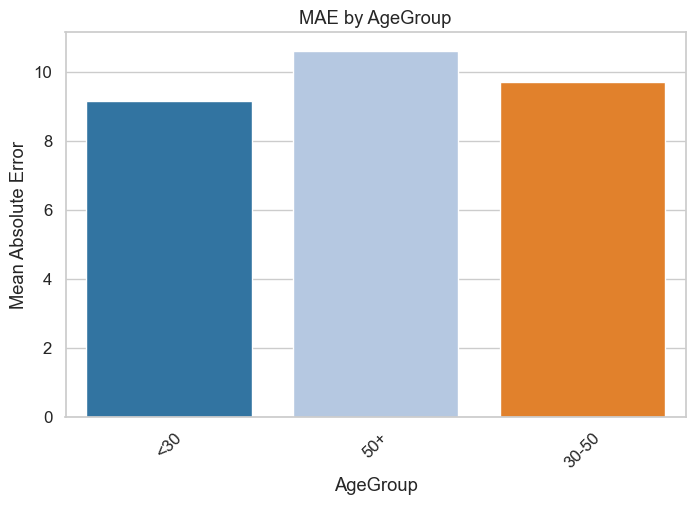

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


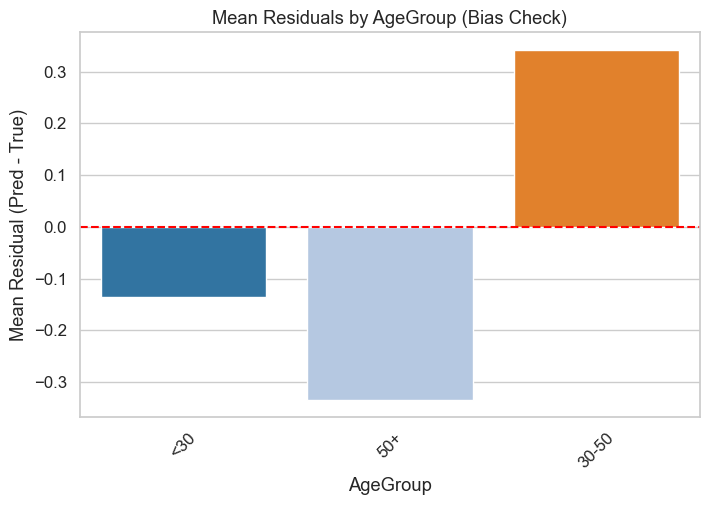

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


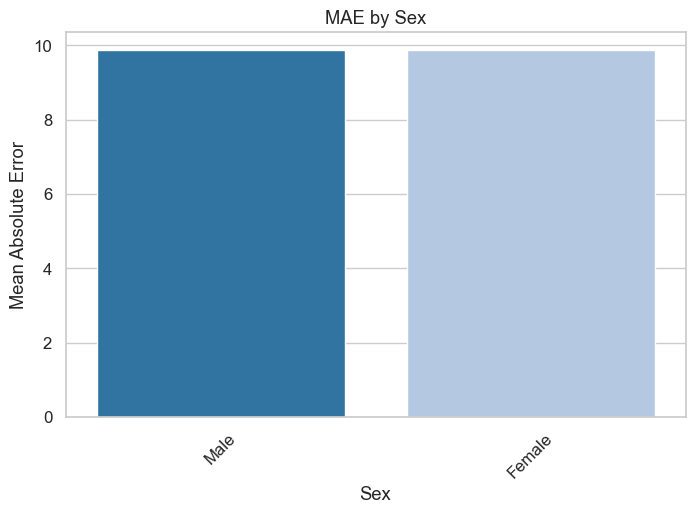

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


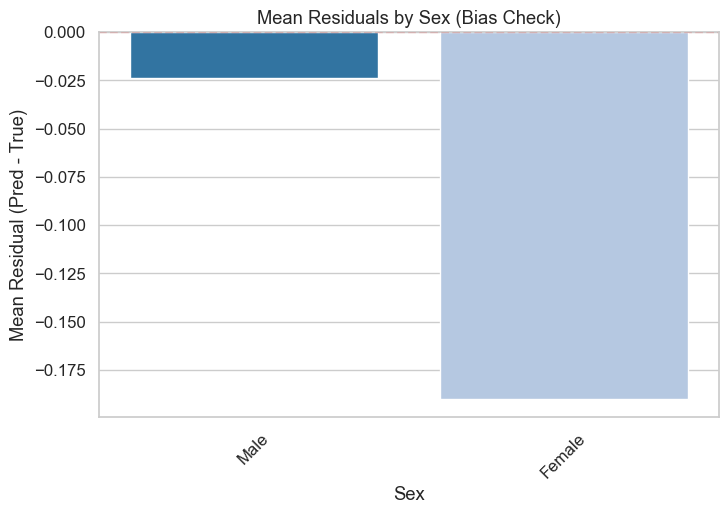

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


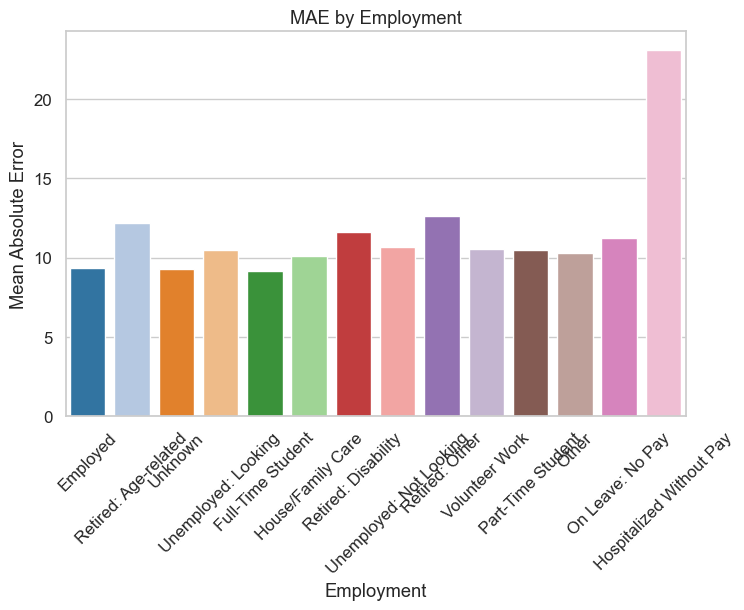

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


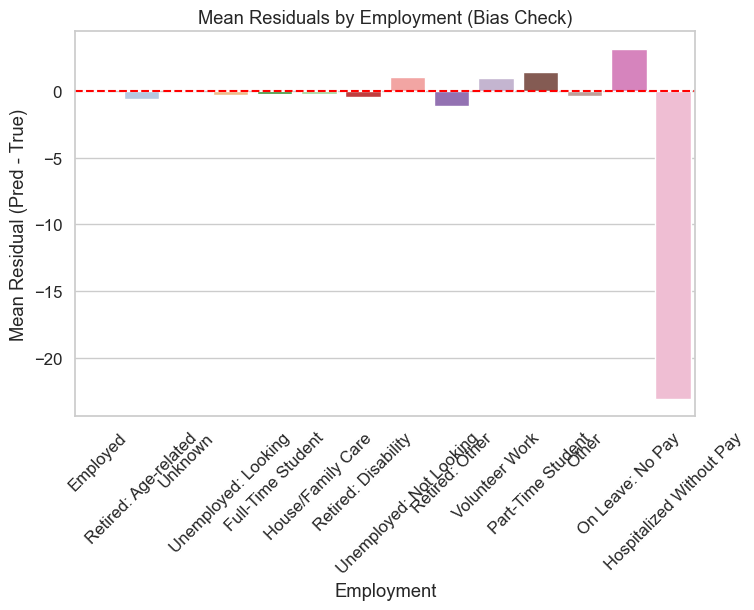

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


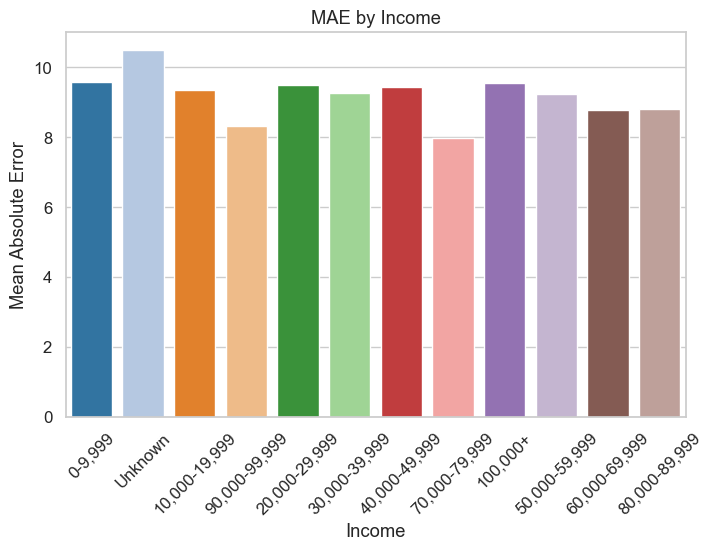

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


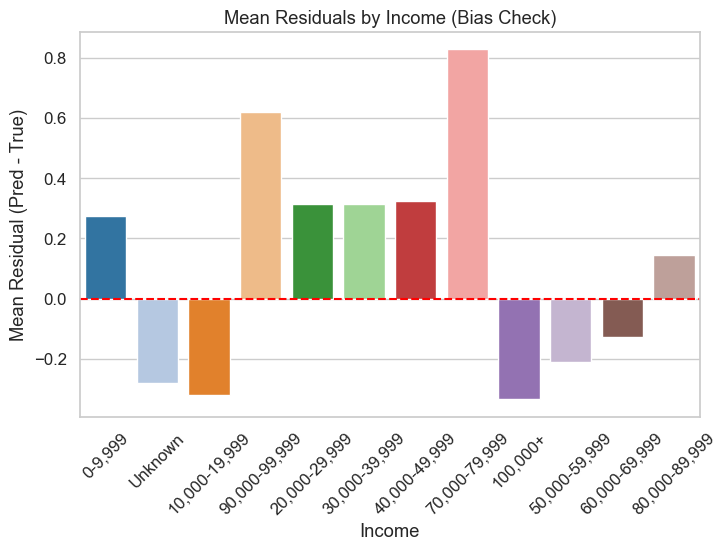

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


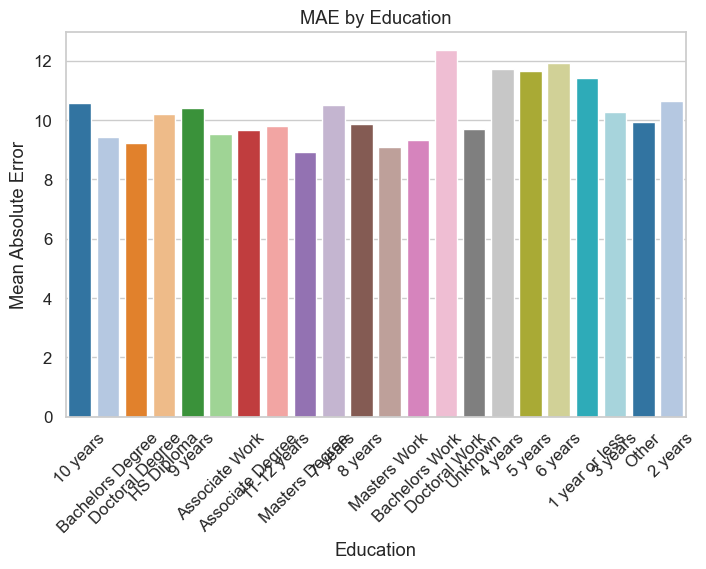

C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\1650867091.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


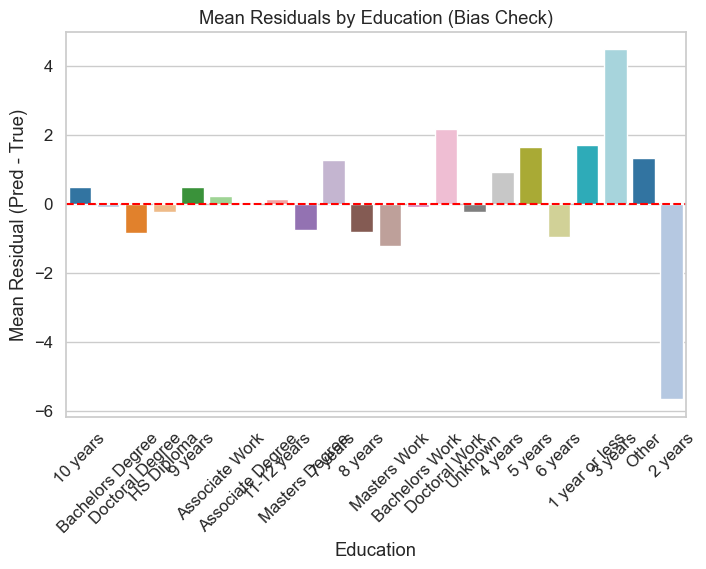


=== Confirmatory tests for bias ===

AgeGroup (ANOVA across: <30, 50+, 30-50): F=2.818, p=0.0598
Sex (Male vs Female): t=0.645, p=0.5186
Employment (ANOVA across: Employed, Retired: Age-related, Unknown, Unemployed: Looking, Full-Time Student, House/Family Care, Retired: Disability, Unemployed: Not Looking, Retired: Other, Volunteer Work, Part-Time Student, Other, On Leave: No Pay, Hospitalized Without Pay): F=0.978, p=0.4702
Income (ANOVA across: 0-9,999, Unknown, 10,000-19,999, 90,000-99,999, 20,000-29,999, 30,000-39,999, 40,000-49,999, 70,000-79,999, 100,000+, 50,000-59,999, 60,000-69,999, 80,000-89,999): F=0.630, p=0.8044
Education (ANOVA across: 10 years, Bachelors Degree, Doctoral Degree, HS Diploma, 9 years, Associate Work, Associate Degree, 11-12 years, Masters Degree, 7 years, 8 years, Masters Work, Bachelors Work, Doctoral Work, Unknown, 4 years, 5 years, 6 years, 1 year or less, 3 years, Other, 2 years): F=0.947, p=0.5284


In [2]:
# ------------------------------------------
# Load model and dataset
# ------------------------------------------
best_model_path = r"C:\Users\saumy\OneDrive\Desktop\tbi_pipeline_final_codes\notebooks\output\models\best_model_final.pkl"
best_model_instance = joblib.load(best_model_path)

filepath = r"../data/processed/df17nov.csv"
df = pd.read_csv(filepath)

# Define features & target
target_col = 'FIM_change'
X = df.drop(columns=[target_col])
y = df[target_col]

# Ensure feature alignment with model
model_features = best_model_instance.feature_names_in_
X = X[model_features]


# ------------------------------------------
# 1️⃣ Define Subgroups
# ------------------------------------------

# Age bins
age_bins = [0, 30, 50, 100]
age_labels = ['<30', '30-50', '50+']
df['AgeGroup'] = pd.cut(df['AGENoPHI'], bins=age_bins, labels=age_labels)

# Sex
df['Sex'] = df['SexF'].map({1: 'Female', 2: 'Male'})

# Employment categories
emp_map = {
    5: 'Employed',
    2: 'Full-Time Student',
    3: 'Part-Time Student',
    7: 'House/Family Care',
    10: 'Unemployed: Looking',
    11: 'Volunteer Work',
    12: 'Retired: Disability',
    13: 'Unemployed: Not Looking',
    14: 'Hospitalized Without Pay',
    15: 'Retired: Other',
    16: 'On Leave: No Pay',
    55: 'Other',
    666: 'Did Not Exist',
    777: 'Refused',
    888: 'Not Applicable',
    9: 'Retired: Age-related'
}
df['Employment'] = df['Emp1'].map(emp_map).fillna('Unknown')

# Income categories
earn_map = {
    1: '0-9,999',
    2: '10,000-19,999',
    3: '20,000-29,999',
    4: '30,000-39,999',
    5: '40,000-49,999',
    6: '50,000-59,999',
    7: '60,000-69,999',
    8: '70,000-79,999',
    9: '80,000-89,999',
    10: '90,000-99,999',
    11: '100,000+',
    666: 'Did Not Exist',
    777: 'Refused',
    888: 'Not Applicable',
    999: 'Unknown'
}
df['Income'] = df['Earn'].map(earn_map).fillna('Unknown')

# Education categories
edu_map = {
    1: '1 year or less', 2: '2 years', 3: '3 years', 4: '4 years', 5: '5 years',
    6: '6 years', 7: '7 years', 8: '8 years', 9: '9 years', 10: '10 years',
    11: '11-12 years', 12: 'HS Diploma', 13: 'Associate Work', 14: 'Associate Degree',
    15: 'Bachelors Work', 16: 'Bachelors Degree', 17: 'Masters Work', 18: 'Masters Degree',
    19: 'Doctoral Work', 20: 'Doctoral Degree', 21: 'Other',
    666: 'Did Not Exist', 999: 'Unknown'
}
df['Education'] = df['EduYears'].map(edu_map).fillna('Unknown')

# Subgroup dictionary
subgroups = {
    'AgeGroup': df['AgeGroup'],
    'Sex': df['Sex'],
    'Employment': df['Employment'],
    'Income': df['Income'],
    'Education': df['Education']
}


# ------------------------------------------
# 2️⃣ Predictions
# ------------------------------------------
y_pred = best_model_instance.predict(X)
residuals = y_pred - y

df['y_pred'] = y_pred
df['Residuals'] = residuals


# ------------------------------------------
# 3️⃣ Metrics per subgroup (with empty-group skip)
# ------------------------------------------
metrics_list = []

for grp_name, grp_col in subgroups.items():
    for category in grp_col.unique():

        idx = grp_col == category

        y_true_grp = y[idx]
        y_pred_grp = y_pred[idx]
        residuals_grp = residuals[idx]

        # Skip categories with zero rows
        if len(y_true_grp) == 0:
            continue

        metrics_list.append({
            'Subgroup': grp_name,
            'Category': category,
            'N': len(y_true_grp),
            'MAE': mean_absolute_error(y_true_grp, y_pred_grp),
            'MSE': mean_squared_error(y_true_grp, y_pred_grp),
            'RMSE': np.sqrt(mean_squared_error(y_true_grp, y_pred_grp)),
            'R2': r2_score(y_true_grp, y_pred_grp),
            'MeanResidual': residuals_grp.mean(),
            'StdResidual': residuals_grp.std()
        })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)


# ------------------------------------------
# 4️⃣ Visualizations
# ------------------------------------------
sns.set(style="whitegrid", palette="tab20", font_scale=1.1)

# Ensure output directory exists
import os
os.makedirs("output/figures", exist_ok=True)

for grp_name in subgroups.keys():

    df_grp = metrics_df[metrics_df['Subgroup'] == grp_name]

    # --- MAE BAR CHART ---
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='Category',
        y='MAE',
        data=df_grp,
        palette="tab20"
    )
    plt.title(f'MAE by {grp_name}')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel(grp_name)
    plt.xticks(rotation=45)

    # Save
    save_path = f"output/figures/residual_analysis_{grp_name}_MAE.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

    # --- MEAN RESIDUALS BAR CHART ---
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='Category',
        y='MeanResidual',
        data=df_grp,
        palette="tab20"
    )
    plt.title(f'Mean Residuals by {grp_name} (Bias Check)')
    plt.ylabel('Mean Residual (Pred - True)')
    plt.xlabel(grp_name)
    plt.axhline(0, color='red', linestyle='--')
    plt.xticks(rotation=45)

    # Save
    save_path = f"output/figures/residual_analysis_{grp_name}_Residuals.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# ------------------------------------------
# 5️⃣ Confirmatory Statistical Tests
# ------------------------------------------
from scipy.stats import ttest_ind, f_oneway

print("\n=== Confirmatory tests for bias ===\n")

for grp_name, grp_col in subgroups.items():

    categories = grp_col.dropna().unique()

    # Collect residuals split by category
    groups = [residuals[grp_col == cat] for cat in categories]

    if len(categories) == 2:
        # Binary → use t-test
        cat1, cat2 = categories
        t_stat, p_val = ttest_ind(groups[0], groups[1], equal_var=False)
        print(f"{grp_name} ({cat1} vs {cat2}): t={t_stat:.3f}, p={p_val:.4f}")

    elif len(categories) > 2:
        # Multi-class → one-way ANOVA
        f_stat, p_val = f_oneway(*groups)
        cats_str = ", ".join([str(c) for c in categories])
        print(f"{grp_name} (ANOVA across: {cats_str}): F={f_stat:.3f}, p={p_val:.4f}")

    else:
        print(f"{grp_name}: Not enough categories for statistical testing.")



In [3]:

# ---------------------------------------------------------
# 1. LOAD MODEL + DATA
# ---------------------------------------------------------
best_model_path = r"C:\Users\saumy\OneDrive\Desktop\tbi_pipeline_final_codes\notebooks\output\models\best_model_final.pkl"
best_model_instance = joblib.load(best_model_path)

filepath = r"../data/processed/df17nov.csv"
df = pd.read_csv(filepath)

target_col = 'FIM_change'
X = df.drop(columns=[target_col])
y = df[target_col]

# Ensure feature alignment
model_features = best_model_instance.feature_names_in_
X = X[model_features]

# ---------------------------------------------------------
# 2. CREATE AGE GROUPS
# ---------------------------------------------------------
age_bins = [0, 30, 50, 100]
age_labels = ['<30', '30-50', '50+']
df['AgeGroup'] = pd.cut(df['AGENoPHI'], bins=age_bins, labels=age_labels)

# ---------------------------------------------------------
# 3. ORIGINAL MODEL PREDICTIONS
# ---------------------------------------------------------
df['y_pred_original'] = best_model_instance.predict(X)
df['Residual_original'] = df['y_pred_original'] - y

# ---------------------------------------------------------
# 4. COMPUTE MEAN RESIDUAL PER AGE GROUP
# ---------------------------------------------------------
age_bias = (
    df.groupby('AgeGroup')['Residual_original']
    .mean()
    .rename("MeanResidual")
)

print("\n=== Mean residual (bias) before calibration ===")
print(age_bias)
print()

# ---------------------------------------------------------
# 5. APPLY GROUP-WISE CALIBRATION (SAFE VERSION)
# ---------------------------------------------------------
def calibrate_row(row, bias_series):
    if pd.isna(row['AgeGroup']):
        # Leave prediction unchanged if AgeGroup is missing
        return row['y_pred_original']
    else:
        return row['y_pred_original'] - bias_series[row['AgeGroup']]

df['y_pred_calibrated'] = df.apply(lambda row: calibrate_row(row, age_bias), axis=1)
df['Residual_calibrated'] = df['y_pred_calibrated'] - y

# ---------------------------------------------------------
# 6. RE-RUN AGEGROUP ANOVA TO CHECK IMPROVEMENT
# ---------------------------------------------------------
groups_original = [
    df[df['AgeGroup'] == grp]['Residual_original']
    for grp in age_labels
]

groups_calibrated = [
    df[df['AgeGroup'] == grp]['Residual_calibrated']
    for grp in age_labels
]

f_orig, p_orig = f_oneway(*groups_original)
f_cal, p_cal = f_oneway(*groups_calibrated)

print("=== ANOVA Before Calibration ===")
print(f"F = {f_orig:.3f}, p = {p_orig:.4f}\n")

print("=== ANOVA After Calibration ===")
print(f"F = {f_cal:.3f}, p = {p_cal:.4f}\n")

# ---------------------------------------------------------
# 7. SAVE OUTPUTS
# ---------------------------------------------------------
df[['y_pred_original', 'y_pred_calibrated', 'Residual_original', 'Residual_calibrated']].to_csv(
    "output/agegroup_calibration_output.csv",
    index=False
)

age_bias.to_csv("output/agegroup_bias_values.csv")

print("Saved calibrated predictions and bias values.")
print("\n Calibration script finished successfully.")


C:\Users\saumy\AppData\Local\Temp\ipykernel_24604\3873893575.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')['Residual_original']



=== Mean residual (bias) before calibration ===
AgeGroup
<30     -0.13562
30-50    0.34216
50+     -0.33449
Name: MeanResidual, dtype: float64

=== ANOVA Before Calibration ===
F = 2.818, p = 0.0598

=== ANOVA After Calibration ===
F = 0.000, p = 1.0000

Saved calibrated predictions and bias values.

 Calibration script finished successfully.


In [4]:
best_model_path = r"C:\Users\saumy\OneDrive\Desktop\tbi_pipeline_final_codes\notebooks\output\models\best_model_final.pkl"
best_model_instance = joblib.load(best_model_path)
params = best_model_instance.get_params()
for k, v in params.items():
    print(f"{k}: {v}")

memory: None
steps: [('imputer', SimpleImputer()), ('scaler', StandardScaler()), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7890856026631795, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.021449802184948644,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=458, n_jobs=-1,
             num_parallel_tree=None, ...))]
transform_input: None
verbose: False
imputer: SimpleImputer()
scaler: StandardScaler()
xgb: XGBRegressor(base_score=None, 

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import resample

# Original and calibrated predictions
y_true = y.to_numpy()
y_pred_orig = df['y_pred_original'].to_numpy()
y_pred_cal  = df['y_pred_calibrated'].to_numpy()

# Bootstrap parameters
B = 5000
mae_diffs, r2_diffs = [], []

for _ in range(B):
    # Resample indices with replacement
    idx = resample(np.arange(len(y_true)), replace=True)
    y_boot = y_true[idx]
    y_orig_boot = y_pred_orig[idx]
    y_cal_boot  = y_pred_cal[idx]
    
    # Compute metrics
    mae_orig = mean_absolute_error(y_boot, y_orig_boot)
    mae_cal  = mean_absolute_error(y_boot, y_cal_boot)
    r2_orig  = r2_score(y_boot, y_orig_boot)
    r2_cal   = r2_score(y_boot, y_cal_boot)
    
    # Store differences (calibrated - original)
    mae_diffs.append(mae_cal - mae_orig)
    r2_diffs.append(r2_cal - r2_orig)

# Confidence intervals
mae_ci = (np.percentile(mae_diffs, 2.5), np.percentile(mae_diffs, 97.5))
r2_ci  = (np.percentile(r2_diffs, 2.5), np.percentile(r2_diffs, 97.5))

print("Bootstrap CI for MAE difference (Cal - Orig):", mae_ci)
print("Bootstrap CI for R² difference (Cal - Orig):", r2_ci)



Bootstrap CI for MAE difference (Cal - Orig): (-0.009895176770207615, -0.0008730838006739463)
Bootstrap CI for R² difference (Cal - Orig): (-0.00014397700579273087, 0.0005900193472658716)
